In [22]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import random
import pandas as pd
import googlemaps
import networkx as nx
from geopy.distance import geodesic
import time
import requests

In [23]:
cities_matrix = pd.read_csv('macedonia_travel_time_matrix.csv',index_col=0)
cities_cords = pd.read_csv('mk.csv')

In [24]:
cities_matrix.head()

,Skopje,Kumanovo,Bitola,Prilep,Tetovo,Štip,Veles,Ohrid,Strumica,Gostivar,...,Zelenikovo,Petrovec,Želino,Star Dojran,Studeničani,Bogovinje,Ilinden,Lipkovo,Makedonska Kamenica,Resen
Skopje,0.0,37.7,167.5,120.0,41.3,61.4,58.8,180.4,125.8,63.5,...,36.5,22.2,36.7,150.4,26.9,52.6,20.1,41.6,102.3,196.1
Kumanovo,36.7,0.0,164.0,116.5,64.4,54.9,55.3,203.5,119.3,86.6,...,36.2,20.6,59.8,146.9,38.9,75.7,24.0,16.3,95.7,192.6
Bitola,157.2,152.9,0.0,52.9,175.9,152.4,122.5,80.9,189.2,153.6,...,144.5,136.5,179.1,180.8,149.9,168.6,146.6,165.7,193.2,36.8
Prilep,108.9,104.6,53.0,0.0,135.4,104.1,74.2,125.7,140.9,137.2,...,96.2,88.2,130.8,132.5,101.6,146.8,98.3,117.5,144.9,81.6
Tetovo,43.2,66.5,176.2,148.4,0.0,90.2,87.2,145.3,154.6,28.4,...,66.7,50.6,11.2,178.8,63.6,14.7,48.9,66.3,131.1,187.8


In [25]:
cities_cords.head()

,city,lat,lng,country,iso2,admin_name,capital,population,population_proper
0,Skopje,41.9961,21.4317,North Macedonia,MK,Skopje,primary,526502.0,526502.0
1,Kumanovo,42.1322,21.7144,North Macedonia,MK,Kumanovo,admin,70842.0,70842.0
2,Bitola,41.0319,21.3347,North Macedonia,MK,Bitola,admin,69287.0,69287.0
3,Prilep,41.3464,21.5542,North Macedonia,MK,Prilep,admin,63308.0,63308.0
4,Tetovo,42.0103,20.9714,North Macedonia,MK,Tetovo,admin,63176.0,63176.0


In [26]:
# Keep only first three columns: ['City', 'lat', 'lon'] - drop any extra columns
cities_cords.drop(cities_cords.columns[3:], axis=1, inplace=True)

In [27]:
cities_cords.head(11)

,city,lat,lng
0,Skopje,41.9961,21.4317
1,Kumanovo,42.1322,21.7144
2,Bitola,41.0319,21.3347
3,Prilep,41.3464,21.5542
4,Tetovo,42.0103,20.9714
5,Štip,41.7358,22.1914
6,Veles,41.7153,21.7753
7,Ohrid,41.1169,20.8019
8,Strumica,41.4375,22.6431
9,Gostivar,41.8000,20.9167


In [28]:
cities_cords.shape

(75, 3)

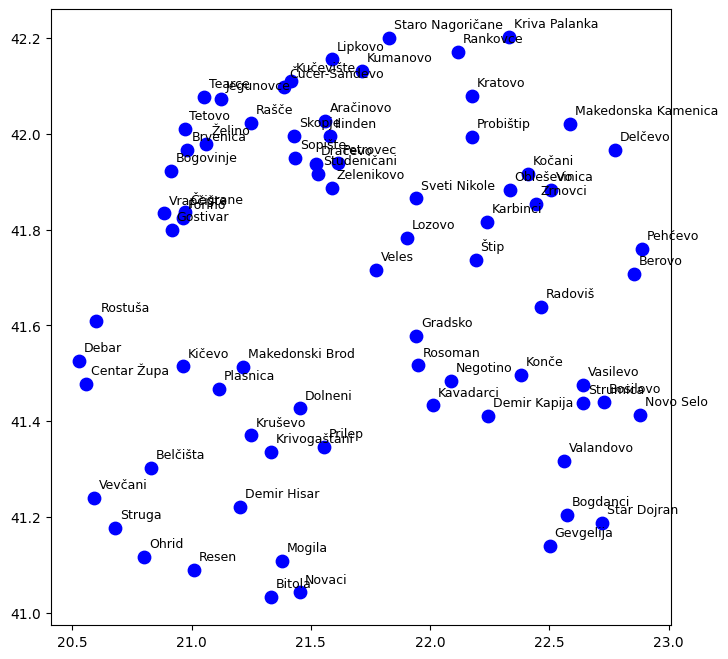

In [ ]:
plt.figure(figsize=(8, 8))

plt.scatter(cities_cords['lng'], cities_cords['lat'], c='blue', s=80)
for i, city in enumerate(cities_cords['city']):
    plt.text(cities_cords['lng'][i] + 0.02, cities_cords['lat'][i] + 0.02, city, fontsize=9)

In [30]:
# ========================================
# Visualization Function
# ========================================

def plot_route(coords_df, route, total_time, iteration=None):
    """
    Plots the route connecting cities in the order given by the route list.
    
    Parameters:
    - coords_df: DataFrame with columns ['City', 'lat', 'lon']
    - route: list of city indices (the order of visiting)
    - total_time: total travel time for the route
    - iteration: optional, current iteration number
    """
    plt.figure(figsize=(8, 8))
    
    # Plot all cities
    plt.scatter(coords_df['lng'], coords_df['lat'], c='blue', s=80)
    for i, city in enumerate(coords_df['city']):
        plt.text(coords_df['lng'][i] + 0.02, coords_df['lat'][i] + 0.02, city, fontsize=9)
    
    # Draw route path
    for i in range(len(route) - 1):
        city1 = coords_df.iloc[route[i]]
        city2 = coords_df.iloc[route[i+1]]
        plt.plot([city1['lng'], city2['lng']], [city1['lat'], city2['lat']], 'r-', lw=2)
    
    # Connect last to first (return trip)
    city1 = coords_df.iloc[route[-1]]
    city2 = coords_df.iloc[route[0]]
    plt.plot([city1['lng'], city2['lng']], [city1['lat'], city2['lat']], 'r--', lw=2)
    
    # Titles and labels
    title = f"Best Route (Time: {total_time:.2f} minutes)"
    if iteration is not None:
        title += f" - Iteration {iteration}"
    plt.title(title)
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.grid(True)
    plt.show()


In [31]:
# ========================================
# Ant Colony Optimization Initialization
# ========================================

def initialize_pheromone(num_cities, tau0=1.0):
    """
    Initializes the pheromone matrix with a base value tau0.
    """
    return np.ones((num_cities, num_cities)) * tau0


def select_next_city(probabilities):
    """
    Selects the next city based on transition probabilities.
    """
    return np.random.choice(range(len(probabilities)), p=probabilities)


def calculate_probabilities(current_city, unvisited, pheromone, distances, alpha, beta):
    """
    Calculates the probability of moving from the current city to each of the unvisited ones.
    """
    tau = np.take(pheromone[current_city], unvisited)
    eta = 1 / np.take(distances[current_city], unvisited)
    
    # Transition rule
    probs = (tau ** alpha) * (eta ** beta)
    probs /= probs.sum()
    return probs


In [32]:
# ========================================
# Main Ant Colony Optimization Procedure
# ========================================

def ant_colony_optimization(dist_df, coords_df, n_ants=20, n_iterations=100,
                            alpha=1, beta=3, evaporation_rate=0.5, Q=100):
    """
    Runs the Ant Colony Optimization to minimize total travel time.
    
    Parameters:
    - dist_df: Pandas DataFrame containing travel times (minutes) between cities
    - coords_df: DataFrame with ['City', 'lat', 'lon']
    """
    cities = dist_df.index.tolist()
    num_cities = len(cities)
    dist_matrix = dist_df.to_numpy()
    pheromone = initialize_pheromone(num_cities)
    
    best_route = None
    best_time = float('inf')
    
    for iteration in range(n_iterations):
        all_routes = []
        all_times = []
        
        for ant in range(n_ants):
            visited = [random.randint(0, num_cities - 1)]
            unvisited = list(set(range(num_cities)) - set(visited))
            
            while unvisited:
                current_city = visited[-1]
                probs = calculate_probabilities(current_city, unvisited, pheromone, dist_matrix, alpha, beta)
                next_city = unvisited[select_next_city(probs)]
                visited.append(next_city)
                unvisited.remove(next_city)
            
            # Complete the tour (return to start)
            total_time = sum(dist_matrix[visited[i], visited[i+1]] for i in range(len(visited)-1))
            total_time += dist_matrix[visited[-1], visited[0]]
            
            all_routes.append(visited)
            all_times.append(total_time)
            
            if total_time < best_time:
                best_time = total_time
                best_route = visited
        
        # Evaporation
        pheromone *= (1 - evaporation_rate)
        
        # Deposit pheromones
        for route, time in zip(all_routes, all_times):
            for i in range(len(route) - 1):
                pheromone[route[i], route[i+1]] += Q / time
            pheromone[route[-1], route[0]] += Q / time  # close the loop
        
        # Visualize progress
        if iteration % 100 == 0 or iteration == n_iterations - 1:
            print(f"Iteration {iteration+1}/{n_iterations}: Best time = {best_time:.2f} minutes")
            # plot_route(coords_df, best_route, best_time, iteration)
    
    return best_route, best_time


Iteration 1/100: Best time = 2667.90 minutes
Iteration 100/100: Best time = 1923.30 minutes

✅ FINAL BEST ROUTE:
Brvenica -> Bogovinje -> Vrapčište -> Gostivar -> Forino -> Čegrane -> Želino -> Tetovo -> Tearce -> Jegunovce -> Rašče -> Skopje -> Sopište -> Dračevo -> Studeničani -> Zelenikovo -> Petrovec -> Ilinden -> Aračinovo -> Kučevište -> Čučer-Sandevo -> Lipkovo -> Kumanovo -> Staro Nagoričane -> Rankovce -> Kriva Palanka -> Kratovo -> Probištip -> Obleševo -> Kočani -> Zrnovci -> Vinica -> Makedonska Kamenica -> Delčevo -> Pehčevo -> Berovo -> Bosilovo -> Novo Selo -> Strumica -> Vasilevo -> Radoviš -> Konče -> Štip -> Karbinci -> Sveti Nikole -> Lozovo -> Veles -> Gradsko -> Rosoman -> Kavadarci -> Negotino -> Demir Kapija -> Gevgelija -> Bogdanci -> Star Dojran -> Valandovo -> Prilep -> Dolneni -> Krivogaštani -> Kruševo -> Demir Hisar -> Mogila -> Bitola -> Novaci -> Resen -> Ohrid -> Struga -> Vevčani -> Belčišta -> Kičevo -> Plasnica -> Makedonski Brod -> Debar -> Centar Žu

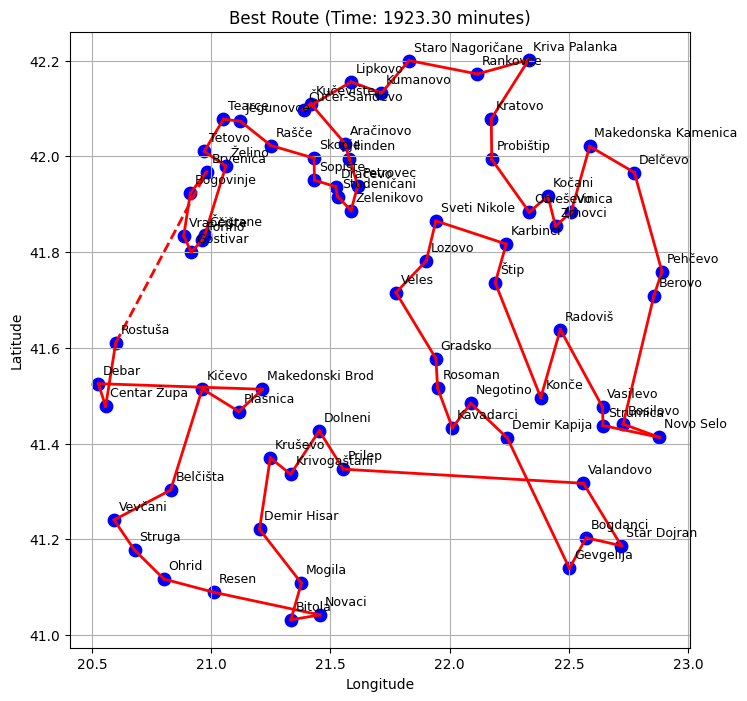

In [33]:
# ========================================
# Run the ACO Simulation
# ========================================

best_route, best_time = ant_colony_optimization(
    dist_df=cities_matrix,        
    coords_df=cities_cords,    
    n_ants=75,
    n_iterations=100,
    alpha=1,
    beta=3,
    evaporation_rate=0.4,
    Q=500
)

print("\n✅ FINAL BEST ROUTE:")
print(" -> ".join(cities_cords['city'].iloc[best_route]))
print(f"Total Travel Time: {best_time:.2f} minutes")

plot_route(cities_cords, best_route, best_time)


Starting randomized search with 10 trials...

Trial 1/10 with params: {'alpha': 1.0288276542121275, 'beta': 8.020158117045181, 'rho': 0.2402547936628878, 'Q': 27.740070676084006, 'n_ants': 20, 'n_iterations': 92}
Iteration 1/92: Best time = 2124.70 minutes
Iteration 92/92: Best time = 1939.20 minutes
Trial 2/10 with params: {'alpha': 0.7140050941720861, 'beta': 5.129424415746827, 'rho': 0.34336956111812694, 'Q': 99.83126434627167, 'n_ants': 12, 'n_iterations': 108}
Iteration 1/108: Best time = 2217.80 minutes
Iteration 101/108: Best time = 1941.40 minutes
Iteration 108/108: Best time = 1941.40 minutes
Trial 3/10 with params: {'alpha': 2.9982448616535393, 'beta': 3.4977924462182215, 'rho': 0.36586339118646627, 'Q': 6.05018253677422, 'n_ants': 21, 'n_iterations': 136}
Iteration 1/136: Best time = 2627.90 minutes
Iteration 101/136: Best time = 1966.70 minutes
Iteration 136/136: Best time = 1966.70 minutes
Trial 4/10 with params: {'alpha': 0.9339371421200883, 'beta': 7.8088418382583535, 'r

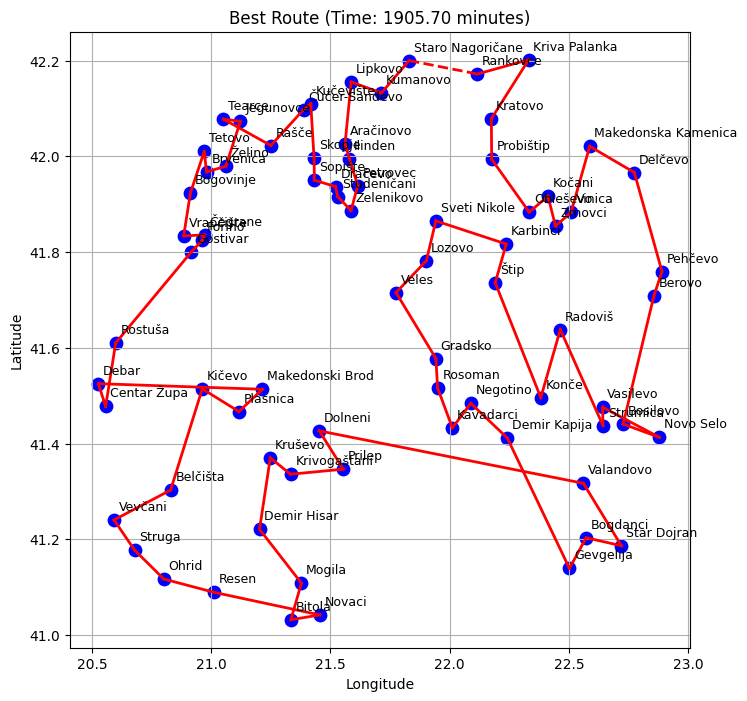

In [35]:

def random_search_aco(distance_df, coords, param_space, n_trials=15):
    """
    Perform a randomized hyperparameter search for Ant Colony Optimization.
    distance_df : pandas DataFrame (distance/time matrix)
    coords : list of (lat, lon) for plotting
    param_space : dict of parameter ranges
    n_trials : how many random combinations to test
    """
    results = []
    print(f"Starting randomized search with {n_trials} trials...\n")
    
    for i in range(n_trials):
        # Randomly sample parameters from ranges
        params = {
            k: random.uniform(v[0], v[1]) if isinstance(v, tuple) else random.choice(v)
            for k, v in param_space.items()
        }
        params['n_ants'] = int(params['n_ants'])
        params['n_iterations'] = int(params['n_iterations'])
        
        print(f"Trial {i+1}/{n_trials} with params: {params}")
        
        best_route, best_time = ant_colony_optimization(
            distance_df,
            coords,
            n_ants=params['n_ants'],
            n_iterations=params['n_iterations'],
            alpha=params['alpha'],
            beta=params['beta'],
            evaporation_rate=params['rho'],
            Q=params['Q']
        )
        
        results.append({
            'params': params,
            'best_time': best_time,
            'best_route': best_route
        })
    
    # Find the best trial
    results_df = pd.DataFrame(results)
    best_trial = results_df.loc[results_df['best_time'].idxmin()]
    best_params = best_trial['params']
    best_route = best_trial['best_route']
    best_time = best_trial['best_time']
    
    print("\n Best parameters found:")
    for k, v in best_params.items():
        print(f"  {k}: {v}")
    print(f" Best route time: {best_trial['best_time']:.2f} minutes")

    plot_route(coords, best_route, best_time)

    return best_params, results_df


# Example parameter search space
param_space = {
    'alpha': (0.5, 3.0),          
    'beta': (1.0, 10.0),          
    'rho': (0.1, 0.9),           
    'Q': (1, 100),                
    'n_ants': (10, 40),         
    'n_iterations': (50, 150)   
}


best_params, search_results = random_search_aco(cities_matrix, cities_cords, param_space, n_trials=10)
